Proces biznesowy, który będziemy analizować, pochodzi z sektora finansowego.**Dotyczy on podejmowania decyzji w sprawie akceptacji lub odrzucenia wniosku o wydanie karty kredytowej**. Sytuacja jest więc relatywnie prosta: potencjalny klient przychodzi do oddziału banku i składa wniosek. W oparciu o zestaw dostępnych cech ekspert (bądź system ekspercki) podejmuje decyzję, czy wydać kartę, czy też nie.

# Opis zbioru danych

Zbiór, który użyję, jest dostępny pod tym linkiem(http://archive.ics.uci.edu/ml/datasets/credit+approval). Zawiera on dane dotyczące 690 wniosków o wydanie karty kredytowej, wraz z decyzją: czy wniosek został zaakceptowany, czy też nie. Są to rzeczywiste dane, w których znajduje się łącznie 16 zmiennych. 15 z nich to **zmiennej objaśniające** (nazwane od A1 do A15). Są one cechami opisującymi osobę składającą wniosek, oraz (prawdopodobnie) danymi behawioralnymi (opisujące np. historią prowadzenia konta, wcześniejsze spłaty zobowiązań wobec banku, etc.).

Pewnie się zastanawiacie, jak chcę interpretować proces decyzyjny, skoro nie mam nazw zmiennych. Na potrzeby projektu przyjmę ich sztuczną interpretację, którą zaczerpnąłem z tej strony. Nazwy zmiennych zamieniam tak, by przypominały nazwy, z którymi można spotkać się w bankowości.

Jedną zmienną, którą zmieniłem w stosunku do tego, co jest widoczne na stronie, jest „ZipCode”, który u mnie będzie saldem konta. Zmienna przyjmuje 170 unikalnych wartości, z czego aż 132 wynoszą 0. Dodatkowo wykonałem analizę zależności zmiennej ze zmienną celu i uznałem, że „Saldo_konta” będzie tu bardziej pasować.

Po zamianie nazwy zmiennych, wraz z ich typami wyglądają następująco:

- Płeć – binarna,
- Wiek – ciągła,
- Zadłużenie – ciągła,
- Stan_cywilny – nominalna,
- Bank – nominalna,
- Wykształcenie – nominalna,
- Pochodzenie – nominalna,
- Lata_pracy – ciągła,
- Poz_hist_kred – binarna,
- Umowa_o_pracę – binarna,
- Score_kredytowy – ciągła,
- Prawo_jazdy – binarna,
- Obywatelstwo – nominalna,
- Saldo_konta – ciągła,
- Przychody – ciągła,
- Wynik – binarna.


Kilka założeń (które możecie dostać od biznesowego biura dla którego realizujecie projekt):

- Jako, że problem dotyczy sektora finansowego, do rozwiązania problemu użyjemy w pełni interpretowalnego algorytmu – drzewa decyzyjnego w wersji CART, z biblioteki Python sklearn.

- Interpretowalność odnosi się nie tylko do samego algorytmu, ale również do jego parametrów. Parametry algorytmu nie mogą utrudniać jego interpretacji. Drzewo nie powinno być zbyt głębokie.

- W interpretacji może przeszkodzić również zbyt duża liczba użytych zmiennych. Analiza głębokiego drzewa z kilkudziesięcioma zmiennymi może przypominać proces szukania z lupą najkrótszej drogi na mapie o dużej skali.

- Dane powinny być przetwarzane w taki sposób, aby możliwie jak najmniej przeszkadzało to w interpretacji osiągniętych wyników. Nie będziemy zatem wykonywać skomplikowanych transformacji zmiennych.

- Jakość modelu będziemy badać za pomocą dokładności predykcji (ang. Accuracy).

# Cel case study 

**Celem jakościowym jest osiągnięcie dokładności na poziomie 80% – 90%**

## Wczytanie danych i niezbędnych bibliotek

In [1]:
# Podstawowe biblioteki
import pandas as pd
import numpy as np
# Podział zbioru, dobór parametrów modelu
from sklearn.model_selection import train_test_split, GridSearchCV
# Dobór zmiennych
from sklearn.feature_selection import RFE
# Walidacja zbioru
from sklearn.model_selection import cross_val_score
# Algorytm drzewa decyzyjnego
from sklearn.tree import DecisionTreeClassifier
# Badanie jakości modelu
from sklearn.metrics import accuracy_score
# Wizualizacja drzewa
from sklearn import tree
import graphviz

## Przygotowanie danych do analizy

W tym kroku przyjrzymy się danym, zbadam ich ogólną strukturę (typy zmiennych, braki i ich liczbę). Zaczynam od analizy braków.

In [2]:
df = pd.read_csv('crx.data', 
                 header=None, 
                 names=['Płeć','Wiek','Zadłużenie','Stan_cywilny','Bank','Wykształcenie','Pochodzenie','Lata_pracy',
                        'Poz_hist_kred','Umowa_o_pracę','Score_kredytowy','Prawo_jazdy','Obywatelstwo','Saldo_konta',
                        'Przychody','Wynik'], 
                 decimal='.', 
                 na_values='?', 
                 dtype = {'Płeć':'category','Stan_cywilny':'category','Bank':'category','Wykształcenie':'category',
                          'Pochodzenie':'category','Poz_hist_kred':'category','Umowa_o_pracę':'category',
                          'Prawo_jazy':'category','Obywatelstwo':'category','Wynik':'category'})

In [3]:
df

,Płeć,Wiek,Zadłużenie,Stan_cywilny,Bank,Wykształcenie,Pochodzenie,Lata_pracy,Poz_hist_kred,Umowa_o_pracę,Score_kredytowy,Prawo_jazdy,Obywatelstwo,Saldo_konta,Przychody,Wynik
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,260.0,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,200.0,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,200.0,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,280.0,750,-


In [4]:
print(str(df.shape[0]) + ' wierszy.')
print(str(df.shape[1]) + ' kolumn.')

690 wierszy.
16 kolumn.


In [5]:
summary = pd.DataFrame(df.dtypes, columns=['Dtype'])
summary['Nulls'] = pd.DataFrame(df.isnull().any())
summary['Sum_of_nulls'] = pd.DataFrame(df.isnull().sum())
summary['Per_of_nulls'] = round((df.apply(pd.isnull).mean()*100),2)
summary.Dtype = summary.Dtype.astype(str)
print(summary)

                    Dtype  Nulls  Sum_of_nulls  Per_of_nulls
Płeć             category   True            12          1.74
Wiek              float64   True            12          1.74
Zadłużenie        float64  False             0          0.00
Stan_cywilny     category   True             6          0.87
Bank             category   True             6          0.87
Wykształcenie    category   True             9          1.30
Pochodzenie      category   True             9          1.30
Lata_pracy        float64  False             0          0.00
Poz_hist_kred    category  False             0          0.00
Umowa_o_pracę    category  False             0          0.00
Score_kredytowy     int64  False             0          0.00
Prawo_jazdy        object  False             0          0.00
Obywatelstwo     category  False             0          0.00
Saldo_konta       float64   True            13          1.88
Przychody           int64  False             0          0.00
Wynik            categor

In [6]:
print(str(round(df.isnull().any(axis=1).sum()/df.shape[0]*100,2))+'% obserwacji zawiera braki w danych.')

5.36% obserwacji zawiera braki w danych.


In [7]:
df.dropna(inplace=True)
print('Pozostało ' + str(df.shape[0]) + ' obserwacji.')

Pozostało 653 obserwacji.


In [8]:
df.select_dtypes(exclude = ['float', 'int']).describe()

,Płeć,Stan_cywilny,Bank,Wykształcenie,Pochodzenie,Poz_hist_kred,Umowa_o_pracę,Prawo_jazdy,Obywatelstwo,Wynik
count,653,653,653,653,653,653,653,653,653,653
unique,2,3,3,14,9,2,2,2,3,2
top,b,u,g,c,v,t,f,f,g,-
freq,450,499,499,133,381,349,366,351,598,357


In [9]:
# zmiana wartości zmiennych
df.Poz_hist_kred.replace(['t','f'],[1,0], inplace=True)
df.Umowa_o_pracę.replace(['t','f'],[1,0], inplace=True)
df.Płeć.replace(['a','b'],[1,0], inplace=True)
df.Prawo_jazdy.replace(['t','f'],[1,0], inplace=True)
df.Wynik.replace(['+','-'],[1,0], inplace=True)

# zmiana typu zmiennych
df['Poz_hist_kred'] = df['Poz_hist_kred'].astype('uint8')
df['Umowa_o_pracę'] = df['Umowa_o_pracę'].astype('uint8')
df['Płeć'] = df['Płeć'].astype('uint8')
df['Prawo_jazdy'] = df['Prawo_jazdy'].astype('uint8')
df['Wynik'] = df['Wynik'].astype('uint8')

# Eksploracyjna analiza danych

W ramach EDA wykonamy dwie podstawowe czynności: weryfikację podstawowych statystyk dotyczących zmiennych numerycznych, weryfikację statystyk dotyczących połączonego zbioru zmiennych: kategorycznych i binarnych. Dla tych ostatnich zbadamy zależność ze zmienną celu poprzez zbudowanie tablicy liczebności (crosstab: badana zmienna vs zmienna celu). Crosstab da nam ogólne spojrzenie na moc predykcyjną danej zmiennej.

Uważam, że warto w tym miejscu zaznaczyć, że celowo pominiemy **analizę korelacji** zależności pomiędzy pozostałymi zmiennymi. **Współliniowość** w drzewie decyzyjnym nam nie zagraża. Podobnie w sposób świadomy pominiemy analizę **odstających wartości**. Przyczyna jest prosta: algorytm drzewa decyzyjnego nie jest wrażliwy na outliery. W przypadku zmiennych numerycznych podział węzłów w drzewie decyzyjnym jest wykonywany na podstawie proporcji obserwacji w zbiorze, a nie na podstawie zakresu wartości.

Już wiecie dlaczego tak lubię drzewa decyzyjne ;)

#### Zmienne numeryczne

In [10]:
df.describe(include=['float', 'int'])

,Wiek,Zadłużenie,Lata_pracy,Score_kredytowy,Saldo_konta,Przychody
count,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000
mean,31.503813,4.829533,2.244296,2.502297,180.359877,1013.761103
std,11.838267,5.027077,3.371120,4.968497,168.296811,5253.278504
min,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.580000,1.040000,0.165000,0.000000,73.000000,0.000000
50%,28.420000,2.835000,1.000000,0.000000,160.000000,5.000000
75%,38.250000,7.500000,2.625000,3.000000,272.000000,400.000000
max,76.750000,28.000000,28.500000,67.000000,2000.000000,100000.000000


#### Zmienne kategoryczne i binarne

In [11]:
df.describe(include=['category'])

,Stan_cywilny,Bank,Wykształcenie,Pochodzenie,Obywatelstwo
count,653,653,653,653,653
unique,3,3,14,9,3
top,u,g,c,v,g
freq,499,499,133,381,598


### Stan cywilny

In [12]:
df.Stan_cywilny.value_counts()

Stan_cywilny
u    499
y    152
l      2
Name: count, dtype: int64

In [13]:
pd.crosstab(df.Stan_cywilny, df.Wynik)

Wynik,0,1
Stan_cywilny,,
l,0,2
u,250,249
y,107,45


# Przygotowanie danych do modelowania

In [14]:
df.describe(include=['category'])

,Stan_cywilny,Bank,Wykształcenie,Pochodzenie,Obywatelstwo
count,653,653,653,653,653
unique,3,3,14,9,3
top,u,g,c,v,g
freq,499,499,133,381,598


In [15]:
df = pd.concat([df, pd.get_dummies(df.Stan_cywilny, prefix='Stan_cywilny__', dtype='int')], axis = 1)
df = pd.concat([df,pd.get_dummies(df.Bank, prefix='Bank__', dtype='int')], axis = 1)
df = pd.concat([df,pd.get_dummies(df.Wykształcenie, prefix='Wykształcenie__', dtype='int')], axis = 1)
df = pd.concat([df,pd.get_dummies(df.Pochodzenie, prefix='Pochodzenie__', dtype='int')], axis = 1)
df = pd.concat([df,pd.get_dummies(df.Obywatelstwo, prefix='Obywatelstwo__', dtype='int')], axis = 1)

In [16]:
df

,Płeć,Wiek,Zadłużenie,Stan_cywilny,Bank,Wykształcenie,Pochodzenie,Lata_pracy,Poz_hist_kred,Umowa_o_pracę,...,Pochodzenie___ff,Pochodzenie___h,Pochodzenie___j,Pochodzenie___n,Pochodzenie___o,Pochodzenie___v,Pochodzenie___z,Obywatelstwo___g,Obywatelstwo___p,Obywatelstwo___s
0,0,30.83,0.000,u,g,w,v,1.25,1,1,...,0,0,0,0,0,1,0,1,0,0
1,1,58.67,4.460,u,g,q,h,3.04,1,1,...,0,1,0,0,0,0,0,1,0,0
2,1,24.50,0.500,u,g,q,h,1.50,1,0,...,0,1,0,0,0,0,0,1,0,0
3,0,27.83,1.540,u,g,w,v,3.75,1,1,...,0,0,0,0,0,1,0,1,0,0
4,0,20.17,5.625,u,g,w,v,1.71,1,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0,21.08,10.085,y,p,e,h,1.25,0,0,...,0,1,0,0,0,0,0,1,0,0
686,1,22.67,0.750,u,g,c,v,2.00,0,1,...,0,0,0,0,0,1,0,1,0,0
687,1,25.25,13.500,y,p,ff,ff,2.00,0,1,...,1,0,0,0,0,0,0,1,0,0
688,0,17.92,0.205,u,g,aa,v,0.04,0,0,...,0,0,0,0,0,1,0,1,0,0


In [17]:
df.drop(['Stan_cywilny', 'Bank', 'Wykształcenie', 'Pochodzenie', 'Obywatelstwo'], axis = 1, inplace = True)

In [18]:
df.Wynik.value_counts(normalize=True)

Wynik
0    0.546708
1    0.453292
Name: proportion, dtype: float64

#### Podział zbioru

- Zbiór treningowy – na nim wykonamy walidację krzyżową. Celem sprawdzianu krzyżowego będzie dobór parametrów algorytmu i zmiennych użytych w modelu.
- Zbiór testowy – finalny sprawdzian dla zbudowanego modelu. Sprawdzimy jak zbudowany algorytm radzi sobie z danymi, których nigdy wcześniej nie widział.

Podział:

- 80% – zbiór treningowy i jednocześnie walidacyjny,
- 20% – zbiór testowy.

In [20]:
y = df.Wynik # kopiuje zmienną celu do osobnej zmiennej i usuwam ją ze zbioru
df.drop('Wynik', axis = 1, inplace = True)
x_tr, x_te, y_tr, y_te = train_test_split(df, y, test_size = 0.2, random_state = 1, stratify = y)

In [21]:
print(y_tr.value_counts(normalize = True))
print(y_te.value_counts(normalize = True))

Wynik
0    0.545977
1    0.454023
Name: proportion, dtype: float64
Wynik
0    0.549618
1    0.450382
Name: proportion, dtype: float64


### Model 1
- dobrór zmiennych: brak
- dobrów parametrów: brak

In [22]:
model = DecisionTreeClassifier(random_state=42)
cv = cross_val_score(model, x_tr, y_tr, cv = 10, scoring = 'accuracy')
print('Średnie Accuracy: ' + str(cv.mean().round(3)))
# print('Stabilność: ' + str((cv.std()*100/cv.mean()).round(3)) + '%')

Średnie Accuracy: 0.785


In [23]:
model.fit(x_tr, y_tr)
pred = model.predict(x_te)
print('Benchmark: ' + str(round(accuracy_score(pred, y_te),3)))

Benchmark: 0.855


### Model 2
- dobrór zmiennych: brak
- dobrów parametrów: GridsearchCV

In [26]:
parameters = {'criterion':('entropy', 'gini'), 
              'splitter':('best','random'), 
              'max_depth':np.arange(1,10), 
              'min_samples_split':np.arange(2,10), 
              'min_samples_leaf':np.arange(1,5)}

In [28]:
classifier = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5)
classifier.fit(x_tr, y_tr)
classifier.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'splitter': 'random'}

In [29]:
model = DecisionTreeClassifier(**classifier.best_params_, random_state=42)

In [31]:
x_tr

,Płeć,Wiek,Zadłużenie,Lata_pracy,Poz_hist_kred,Umowa_o_pracę,Score_kredytowy,Prawo_jazdy,Saldo_konta,Przychody,...,Pochodzenie___ff,Pochodzenie___h,Pochodzenie___j,Pochodzenie___n,Pochodzenie___o,Pochodzenie___v,Pochodzenie___z,Obywatelstwo___g,Obywatelstwo___p,Obywatelstwo___s
514,0,22.67,2.540,2.585,1,0,0,0,0.0,0,...,0,1,0,0,0,0,0,1,0,0
519,0,39.17,1.710,0.125,1,1,5,1,480.0,0,...,0,0,0,0,0,1,0,1,0,0
125,0,34.92,5.000,7.500,1,1,6,1,0.0,1000,...,0,1,0,0,0,0,0,1,0,0
211,0,24.33,6.625,5.500,1,0,0,1,100.0,0,...,0,0,0,0,0,1,0,0,0,1
27,0,56.58,18.500,15.000,1,1,17,1,0.0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,1,18.25,10.000,1.000,0,1,1,0,120.0,1,...,0,0,0,0,0,1,0,1,0,0
523,1,22.50,8.500,1.750,1,1,10,0,80.0,990,...,0,0,0,0,0,1,0,1,0,0
638,0,28.58,3.625,0.250,0,0,0,1,100.0,0,...,0,0,0,0,0,1,0,1,0,0
119,1,20.75,10.335,0.335,1,1,1,1,80.0,50,...,0,1,0,0,0,0,0,1,0,0


In [30]:
model.fit(x_tr, y_tr)
pred = model.predict(x_te)
print('Model 2: ' + str(round(accuracy_score(pred, y_te),3)))

Model 2: 0.878


### Model 3
- dobrór zmiennych: feature_importances
- dobrów parametrów: GridsearchCV

In [32]:
model = DecisionTreeClassifier(**classifier.best_params_, random_state=42)

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

model.fit(x_tr, y_tr)
feature_importances = model.feature_importances_
feature_importances

array([0.        , 0.        , 0.        , 0.        , 0.88621253,
       0.08283604, 0.        , 0.        , 0.        , 0.        ,
       0.03095143, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [34]:
feature_names = x_tr.columns
feature_names

Index(['Płeć', 'Wiek', 'Zadłużenie', 'Lata_pracy', 'Poz_hist_kred',
       'Umowa_o_pracę', 'Score_kredytowy', 'Prawo_jazdy', 'Saldo_konta',
       'Przychody', 'Stan_cywilny___l', 'Stan_cywilny___u', 'Stan_cywilny___y',
       'Bank___g', 'Bank___gg', 'Bank___p', 'Wykształcenie___aa',
       'Wykształcenie___c', 'Wykształcenie___cc', 'Wykształcenie___d',
       'Wykształcenie___e', 'Wykształcenie___ff', 'Wykształcenie___i',
       'Wykształcenie___j', 'Wykształcenie___k', 'Wykształcenie___m',
       'Wykształcenie___q', 'Wykształcenie___r', 'Wykształcenie___w',
       'Wykształcenie___x', 'Pochodzenie___bb', 'Pochodzenie___dd',
       'Pochodzenie___ff', 'Pochodzenie___h', 'Pochodzenie___j',
       'Pochodzenie___n', 'Pochodzenie___o', 'Pochodzenie___v',
       'Pochodzenie___z', 'Obywatelstwo___g', 'Obywatelstwo___p',
       'Obywatelstwo___s'],
      dtype='object')

In [36]:
# Sortowanie ważności cech malejąco
indices = np.argsort(feature_importances)[::-1]
indices

array([ 4,  5, 10, 41, 11, 18, 17, 16, 15, 14, 13, 12,  9, 40,  8,  7,  6,
        3,  2,  1, 19, 20, 21, 22, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30,
       29, 28, 27, 26, 25, 24, 23,  0], dtype=int64)

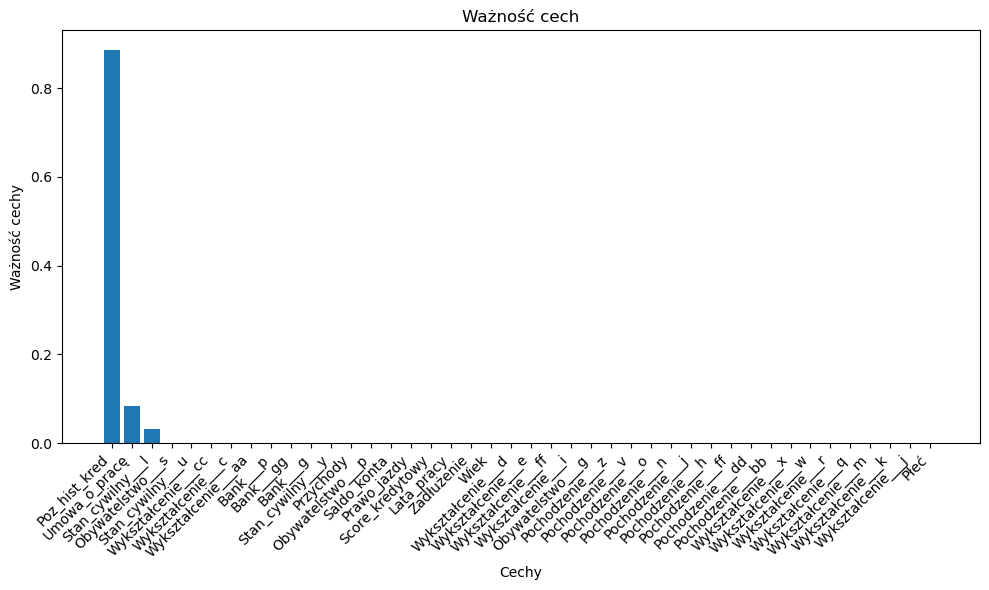

In [37]:
import matplotlib.pyplot as plt
# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.title('Ważność cech')
plt.bar(range(x_tr.shape[1]), feature_importances[indices])
plt.xticks(range(x_tr.shape[1]), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Cechy')
plt.ylabel('Ważność cechy')
plt.tight_layout()
plt.show()

### Model 4
- dobrór zmiennych: RFE
- dobrów parametrów: GridsearchCV

In [62]:
def select_features_rfe(X, y, n_features_to_select=None):
    # Inicjalizacja klasyfikatora DecisionTree
    dt_classifier = DecisionTreeClassifier()
    
    # Utworzenie RFE
    rfe = RFE(
        estimator=dt_classifier, 
        n_features_to_select=n_features_to_select,
        step=1
    )
    
    # Dopasowanie RFE
    rfe.fit(X, y)
    
    # Pobranie nazw wybranych cech
    selected_features = X.columns[rfe.support_].tolist()
    
    # Opcjonalna ocena wybranych cech
    X_selected = X[selected_features]
    cv_scores = cross_val_score(dt_classifier, X_selected, y, cv=5)
    
    return {
        'features': selected_features,
        'cv_scores': cv_scores,
        'mean_score': cv_scores.mean()
    }

In [63]:
result = select_features_rfe(x_tr, y_tr, n_features_to_select=9)
print(result['features'])

['Wiek', 'Zadłużenie', 'Lata_pracy', 'Poz_hist_kred', 'Score_kredytowy', 'Saldo_konta', 'Przychody', 'Stan_cywilny___l', 'Obywatelstwo___g']


In [64]:
cols = result['features']

In [65]:
cols

['Wiek',
 'Zadłużenie',
 'Lata_pracy',
 'Poz_hist_kred',
 'Score_kredytowy',
 'Saldo_konta',
 'Przychody',
 'Stan_cywilny___l',
 'Obywatelstwo___g']

In [66]:
classifier2 = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5)
classifier2.fit(x_tr[cols], y_tr)
print(classifier2.best_params_)

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 7, 'splitter': 'random'}


In [75]:
model = DecisionTreeClassifier(**classifier2.best_params_, random_state=42)

In [76]:
model.fit(x_tr[cols], y_tr)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2,
                       min_samples_split=7, random_state=42, splitter='random')

In [77]:
pred = model.predict(x_te[cols])
print('Finalny wynik to: ' + str(round(accuracy_score(pred, y_te),3)))

Finalny wynik to: 0.878


# Wizualizacja i interpretacja wyników

In [78]:
import graphviz

In [79]:
dot_data = tree.export_graphviz(model, out_file=None,
feature_names=cols,
class_names=['0','1'],
filled=True, rounded=True,
special_characters=True)
graph = graphviz.Source(dot_data)

In [80]:
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('dtree_render',view=True)

'dtree_render.png'

In [81]:
samples = x_te[cols].sample(3).sort_index()
print(samples)

      Wiek  Zadłużenie  Lata_pracy  Poz_hist_kred  Score_kredytowy  \
96   23.00       0.625       0.125              1                0   
616  22.67       0.750       1.585              0                1   
628  29.25      13.000       0.500              0                0   

     Saldo_konta  Przychody  Stan_cywilny___l  Obywatelstwo___g  
96         180.0          1                 0                 1  
616        400.0          9                 0                 1  
628        228.0          0                 0                 1  


In [82]:
print(y_te[y_te.index.isin(samples.index)].sort_index())

96     0
616    0
628    0
Name: Wynik, dtype: uint8


In [83]:
print(model.predict(samples))

[1 0 0]
